In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
from modules.results import Posterior, PointEstimates

In [208]:
# res = np.load('results/aquila_obs/mcmc_frag_trueAq_seedfold31_nfolds4_fold1_imT0_300_gmmCY2014.npz')
res_dir = 'results/aquila_obs/'
imo = 'pga'
gmmo = 'B2011'
seedfold = 31
foldnum = 1

str_load = 'mcmc_frag_trueAq_seedfold'+str(seedfold)+ '_nfolds4_fold' + str(foldnum)
str_im = '_im' + imo + '_gmm' + gmmo
res = np.load(res_dir + str_load + str_im + '.npz')

if imo[0] == 'T': imstr = 'SA' + imo
if imo == 'pga': imstr = 'PGA'
if gmmo == 'CY2014': 
    gmmstr = 'ChiouYoungs2014Italy'
    scmstr = 'BodenmannEtAl2023'
    gmmcombo = 2
elif gmmo == 'B2011':
    gmmstr = 'BindiEtAl2011'
    scmstr = 'EspositoIervolino2012'
    gmmcombo = 1

In [209]:
args = {
    'im_string': imstr, # ...
    'GMM': gmmstr, # ...
    'SCM': scmstr, # ...
    'list_ds': [0, 1, 2, 3, 4, 5], # Ordered list with possible damage states
    'list_bc': ['A-L', 'A-MH', 'B-L', 'B-MH', 'C1-L', 'C1-MH'], # List with possible building classes
    'mcmc_seed': 0, # Seed for MCMC
    'mcmc': {
        'num_samples': 750, # Number of samples per Markov chain
        'num_warmup': 1000, # Number of warmup steps per Markov chain
        'num_chains': 4 # Number of Markov chains    
            }
        }

args['n_ds'] = len(args['list_ds']) # Number of possible damage states
args['n_bc'] = len(args['list_bc']) # Number of building classes

In [210]:
etas = res['etas_tildes']
eta1 = etas[:, :, 0]
eta1 = eta1[:, :, None]
deltas = np.diff(etas, axis=-1)
betas = res['betas']
betas2 = np.zeros((6, 4, 750))
eta1_2 = np.zeros((6, 1, 4, 750))
deltas2 = np.zeros((6, 4, 4, 750))
for bc in range(args['n_bc']):
    betas2[bc, :, :] = betas[bc, :].reshape(4, 750)
    eta1_2[bc, 0, :, :] = eta1[bc, :, 0].reshape(4, 750)
    for ds in range(args['n_ds']-2):
        deltas2[bc, ds, :, :] = deltas[bc,:,ds].reshape(4, 750)

In [211]:
betas = xr.DataArray(betas2, dims = ['bc', 'chain', 'draw'], 
                  coords = {'bc':args['list_bc']}, 
                  name = 'beta')
eta = xr.DataArray(eta1_2, dims = ['bc', 'ds1', 'chain', 'draw'], 
                  coords = {'bc':args['list_bc'], 'ds1': [args['list_ds'][1]]}, 
                  name = 'eta')
deltas = xr.DataArray(deltas2, dims = ['bc', 'ds2+', 'chain', 'draw'], 
                  coords = {'bc':args['list_bc'], 'ds2+': args['list_ds'][2:]}, 
                  name = 'deltas')

In [212]:
ds = xr.Dataset({'beta': betas, 'eta': eta, 'deltas': deltas}).stack(sample=("chain", "draw"))
ds.attrs['created_at'] = datetime.datetime.now().isoformat()
ds.attrs['arviz_version'] = '0.15.1'
ds.attrs['inference_library'] = 'numpyro'
ds.attrs['inference_library_version'] = '0.13.2'
ds.attrs['IM'] = args['im_string']
ds.attrs['IM_unit'] = 'g [m/s2]'
ds.attrs['GMM'] = args['GMM']
ds.attrs['SCM'] = args['SCM']
ds.attrs['seed_subsampling'] = str(seedfold)
ds.attrs['subsample_number'] = str(foldnum)

In [213]:
ds

<xarray.Dataset>
Dimensions:  (bc: 6, sample: 3000, ds1: 1, ds2+: 4)
Coordinates:
  * bc       (bc) <U5 'A-L' 'A-MH' 'B-L' 'B-MH' 'C1-L' 'C1-MH'
  * ds1      (ds1) int32 1
  * ds2+     (ds2+) int32 2 3 4 5
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 742 743 744 745 746 747 748 749
Data variables:
    beta     (bc, sample) float64 0.7379 0.7089 0.7059 ... 0.8029 0.7301 0.6659
    eta      (bc, ds1, sample) float64 -2.791 -2.436 -2.575 ... -1.598 -1.971
    deltas   (bc, ds2+, sample) float64 0.6349 0.6352 0.6626 ... 0.3872 0.3446
Attributes:
    created_at:                 2023-10-23T13:22:23.727208
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.13.2
    IM:                         PGA
    IM_unit:                    g [m/s2]
    GMM:                        BindiEtAl2011
    SCM:                        EspositoIervolino2012
    seed_subsampling:           31
    subsample_number:           1

In [216]:
posterior = Posterior(ds, args)

In [217]:
posterior.get_mean_fragparams()

,beta,theta1,theta2,theta3,theta4,theta5
bc,,,,,,
A-L,0.726239,0.154719,0.245262,0.296421,0.403972,0.641371
A-MH,0.629227,0.130481,0.220661,0.268941,0.360299,0.592059
B-L,0.866674,0.255382,0.454977,0.561208,0.763854,1.178327
B-MH,0.799955,0.198099,0.359611,0.442418,0.592960,0.944628
C1-L,0.867578,0.345819,0.643576,0.782946,1.008184,1.626171
C1-MH,0.799963,0.279963,0.518728,0.639260,0.856081,1.175046


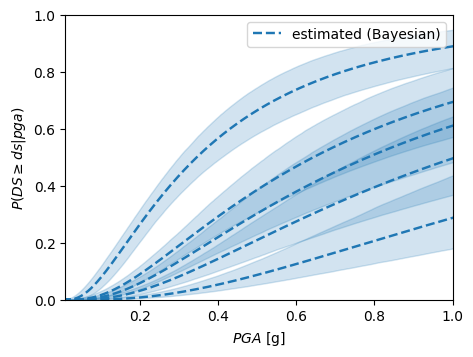

In [218]:
import matplotlib.pyplot as plt
color = 'tab:blue'
bc = 'C1-L'
im = np.linspace(0.001,1.5,1000)
fig, ax = plt.subplots(figsize=(5,3.7))
posterior.plot_frag_funcs(ax, bc=bc, im=im, color=color, 
                    kwargsm={'ls': '--', 'lw': 1.75, 'label': 'estimated (Bayesian)'})
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_ylabel('$P(DS \geq ds|pga)$')
ax.set_xlabel('$PGA$ [g]')
ax.legend()
plt.show()

In [219]:
savestr = ('Bayesian_frag_Aquila_im' + imstr + 
           '_GMMcombo' + str(gmmcombo) + 
           '_seedsubsampling' + str(seedfold) + '.nc')
savestr = res_dir + savestr

In [220]:
savestr

'results/aquila_obs/Bayesian_frag_Aquila_imPGA_GMMcombo1_seedsubsampling31.nc'

In [221]:
ds[['beta', 'eta', 'deltas']].unstack().to_netcdf(savestr)

In [11]:
ds

NameError: name 'ds' is not defined

In [261]:
# res = np.load('results/aquila_obs/mcmc_frag_trueAq_seedfold31_nfolds4_fold1_imT0_300_gmmCY2014.npz')
res_dir = 'results/aquila_obs/'
imo = 'T0_300'
gmmo = 'CY2014'

str_load = 'fixedIM_frag_trueAq'
str_im = '_im' + imo + '_gmm' + gmmo
res = np.load(res_dir + str_load + str_im + '.npz')

if imo[0] == 'T': imstr = 'SA' + imo
if imo == 'pga': imstr = 'PGA'
if gmmo == 'CY2014': 
    gmmstr = 'ChiouYoungs2014Italy'
    scmstr = 'BodenmannEtAl2023'
    gmmcombo = 2
elif gmmo == 'B2011':
    gmmstr = 'BindiEtAl2011'
    scmstr = 'EspositoIervolino2012'
    gmmcombo = 1

In [262]:
args = {
    'im_string': imstr, # ...
    'GMM': gmmstr, # ...
    'SCM': scmstr, # ...
    'list_ds': [0, 1, 2, 3, 4, 5], # Ordered list with possible damage states
    'list_bc': ['A-L', 'A-MH', 'B-L', 'B-MH', 'C1-L', 'C1-MH'], # List with possible building classes
        }

args['n_ds'] = len(args['list_ds']) # Number of possible damage states
args['n_bc'] = len(args['list_bc']) # Number of building classes

In [263]:
etas = res['etas_tildes']
eta1 = etas[:, 0]
eta1 = eta1[:, None]
deltas = np.diff(etas, axis=-1)
betas = res['betas']

In [264]:
betas = xr.DataArray(betas, dims = ['bc'], 
                  coords = {'bc':args['list_bc']}, 
                  name = 'beta')
eta = xr.DataArray(eta1, dims = ['bc', 'ds1'], 
                  coords = {'bc':args['list_bc'], 'ds1': [args['list_ds'][1]]}, 
                  name = 'eta')
deltas = xr.DataArray(deltas, dims = ['bc', 'ds2+'], 
                  coords = {'bc':args['list_bc'], 'ds2+': args['list_ds'][2:]}, 
                  name = 'deltas')
ds = xr.Dataset({'beta': betas, 'eta': eta, 'deltas': deltas})
ds.attrs['created_at'] = datetime.datetime.now().isoformat()
ds.attrs['inference_library'] = 'numpyro'
ds.attrs['inference_library_version'] = '0.13.2'
ds.attrs['IM'] = args['im_string']
ds.attrs['IM_unit'] = 'g [m/s2]'
ds.attrs['GMM'] = args['GMM']
ds.attrs['SCM'] = args['SCM']

In [265]:
ds

<xarray.Dataset>
Dimensions:  (bc: 6, ds1: 1, ds2+: 4)
Coordinates:
  * bc       (bc) <U5 'A-L' 'A-MH' 'B-L' 'B-MH' 'C1-L' 'C1-MH'
  * ds1      (ds1) int32 1
  * ds2+     (ds2+) int32 2 3 4 5
Data variables:
    beta     (bc) float64 1.155 1.007 1.277 1.219 1.447 1.261
    eta      (bc, ds1) float64 -1.14 -1.568 -0.4311 -0.7222 -0.04196 -0.2891
    deltas   (bc, ds2+) float64 0.5054 0.2257 0.3858 ... 0.2397 0.3468 0.3944
Attributes:
    created_at:                 2023-10-23T13:36:07.696708
    inference_library:          numpyro
    inference_library_version:  0.13.2
    IM:                         SAT0_300
    IM_unit:                    g [m/s2]
    GMM:                        ChiouYoungs2014Italy
    SCM:                        BodenmannEtAl2023

In [266]:
savestr = ('FixedIM_frag_Aquila_im' + imstr + 
           '_GMMcombo' + str(gmmcombo) + '.nc')
savestr = res_dir + savestr
savestr

'results/aquila_obs/FixedIM_frag_Aquila_imSAT0_300_GMMcombo2.nc'

In [267]:
ds[['beta', 'eta', 'deltas']].to_netcdf(savestr)

In [32]:
res_dir = 'results/aquila_obs/'
imstr = 'SAT0_300'
gmmcombo = 1

args = {
    'im_string': 'SAT0_300', # ...
    'list_ds': [0, 1, 2, 3, 4, 5], # Ordered list with possible damage states
    'list_bc': ['A-L', 'A-MH', 'B-L', 'B-MH', 'C1-L', 'C1-MH'], # List with possible building classes
        }

args['n_ds'] = len(args['list_ds']) # Number of possible damage states
args['n_bc'] = len(args['list_bc']) # Number of building classes

str_load = ('FixedIM_frag_Aquila_im' + imstr + 
           '_GMMcombo' + str(gmmcombo) + '.nc')
res = xr.open_dataset(res_dir + str_load)


In [34]:
'ds1' in res

True

In [13]:
res = PointEstimates(res, args)

In [20]:
res.params.attrs

{'created_at': '2023-10-23T13:35:16.919047',
 'inference_library': 'numpyro',
 'inference_library_version': '0.13.2',
 'IM': 'SAT0_300',
 'IM_unit': 'g [m/s2]',
 'GMM': 'BindiEtAl2011',
 'SCM': 'EspositoIervolino2012'}

In [31]:
'ds1' in res.params

True

In [22]:
np.append(0,res.params.ds.values)

array([0, 1, 2, 3, 4, 5])

In [15]:
res.get_fragparams()

,beta,theta1,theta2,theta3,theta4,theta5
bc,,,,,,
A-L,1.086180,0.182356,0.310389,0.394749,0.595695,1.130742
A-MH,0.963593,0.141247,0.252430,0.323579,0.476081,0.957800
B-L,1.204579,0.391054,0.780680,1.013836,1.504693,2.647424
B-MH,1.204865,0.288737,0.597169,0.781365,1.151633,2.191213
C1-L,1.354174,0.622019,1.471803,1.933934,2.756366,5.433068
C1-MH,1.170000,0.463306,1.026609,1.351502,2.014431,3.161041


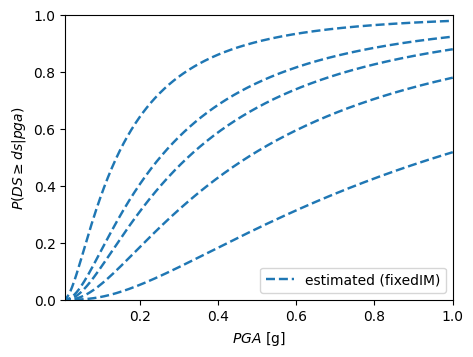

In [10]:
import matplotlib.pyplot as plt
color = 'tab:blue'
bc = 'A-MH'
im = np.linspace(0.001,1,500)
fig, ax = plt.subplots(figsize=(5,3.7))
res.plot_frag_funcs(ax, bc = bc, im = im, color = 'tab:blue', 
                    kwargs={'ls': '--', 'lw': 1.75, 'label': 'estimated (fixedIM)'})
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_ylabel('$P(DS \geq ds|pga)$')
ax.set_xlabel('$PGA$ [g]')
ax.legend()
plt.show()